#The goal of Submission 2 will be to price a vanilla European call option, except we will now allow the volatility term to vary

#1. Using a simple Fourier pricing technique (using 𝑁 = 100 intervals, and using an effective upper bound of integration of 30), price a vanilla call option assuming that the underlying share follows the Heston model dynamics.
#Use the parameter values from the previous section, as well as the following parameter values:


#𝑣0=0.06
#κ=9
#θ=0.06
#𝜌=−0.4

#We will now simulate a share price path

In [9]:
##Imports and constants
import numpy as np
from scipy.stats import norm
from scipy.stats import uniform
import numpy.matlib
import matplotlib.pyplot as plt
import math
import random

In [10]:
#Share specific information
S0 = 100
v0 = 0.06
kappa = 9
theta = 0.06
rho = -0.4
r = 0.08
sigma = 0.3

#Call specific information
K = 100
T = 1
k_log = np.log(K)

#Approximation information
t_max = 30
N = 100

In [12]:
#Characteristic function code

a = sigma**2/2
def b(u):
    return kappa - rho*sigma*1j*u
def c(u):
    return -(u**2+1j*u)/2
def d(u):
    return np.sqrt(b(u)**2-4*a*c(u))
def xminus(u):
    return (b(u)-d(u))/(2*a)
def xplus(u):
    return (b(u)+d(u))/(2*a)
def g(u):
    return xminus(u)/xplus(u)
def C(u):
    val1 = T*xminus(u)-np.log((1-g(u)*np.exp(-T*d(u)))/(1-g(u)))/a
    return r*T*1j*u + theta*kappa*val1
def D(u):
    val1 = 1-np.exp(-T*d(u))
    val2 = 1-g(u)*np.exp(-T*d(u))    
    return (val1/val2)*xminus(u)
def log_char(u):
    return np.exp(C(u) + D(u)*v0 +1j*u*np.log(S0))
def adj_char(u):
    return log_char(u-1j)/log_char(-1j)

In [13]:
#Variables to vectorize the code

delta_t = t_max/N
from_1_to_N = np.linspace(1,N,N)
t_n = (from_1_to_N-1/2)*delta_t
print (t_n)

[ 0.15  0.45  0.75  1.05  1.35  1.65  1.95  2.25  2.55  2.85  3.15  3.45
  3.75  4.05  4.35  4.65  4.95  5.25  5.55  5.85  6.15  6.45  6.75  7.05
  7.35  7.65  7.95  8.25  8.55  8.85  9.15  9.45  9.75 10.05 10.35 10.65
 10.95 11.25 11.55 11.85 12.15 12.45 12.75 13.05 13.35 13.65 13.95 14.25
 14.55 14.85 15.15 15.45 15.75 16.05 16.35 16.65 16.95 17.25 17.55 17.85
 18.15 18.45 18.75 19.05 19.35 19.65 19.95 20.25 20.55 20.85 21.15 21.45
 21.75 22.05 22.35 22.65 22.95 23.25 23.55 23.85 24.15 24.45 24.75 25.05
 25.35 25.65 25.95 26.25 26.55 26.85 27.15 27.45 27.75 28.05 28.35 28.65
 28.95 29.25 29.55 29.85]


In [14]:
#Estimate for the integrals

first_integral = sum((((np.exp(-1j*t_n*k_log)*adj_char(t_n)).imag)/t_n)*delta_t)
second_integral = sum((((np.exp(-1j*t_n*k_log)*log_char(t_n)).imag)/t_n)*delta_t)

In [15]:
#Fourier estimate of the call price
fourier_call_val = S0 *(1/2 +first_integral/np.pi)-np.exp(-r*T)*K*(1/2 + second_integral/np.pi)

print("fourier_call_val: ", fourier_call_val)

fourier_call_val:  13.734895692109077


In [16]:
# For the sake of comparison, we can also calculate the call price under the Black-Scholes
# assumptions and constant implied volatility 30%, as below.
 
d_1 = (np.log(S0/K)+(r + sigma**2/2)*(T))/(sigma*np.sqrt(T))
d_2 = d_1 - sigma * np.sqrt(T)
analytic_call_price = S0*norm.cdf(d_1)-K*np.exp(-r*(T))*norm.cdf(d_2)

print("analytic_call_price: ", analytic_call_price)

# Observe there is wide difference between option prices calculated by above two models.

analytic_call_price:  15.711312547892973


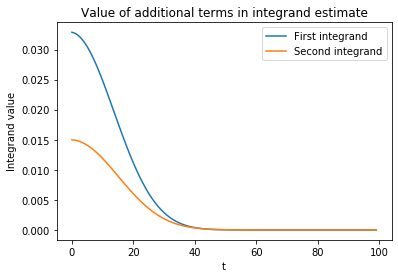

In [17]:
# Observe the two integrands of the characteristic pricing method converges to zero pretty quickly.
#the additional terms in the integral approximation go to zero.
plt.title("Value of additional terms in integrand estimate")
plt.plot((((np.exp(-1j*t_n*k_log)*adj_char(t_n)).imag)/t_n)*delta_t, label="First integrand")
plt.plot((((np.exp(-1j*t_n*k_log)*log_char(t_n)).imag)/t_n)*delta_t, label="Second integrand")
plt.xlabel("t")
plt.ylabel("Integrand value")
plt.legend()
plt.show()

#2. Share path Simulation
#1. For each sample sizes ranges from 1000 to 50000, iterate through each month
#2. Calculate volatilty for the month which function of previous month stock price and some constant sigma
#3. Calculate current stock price, using the formula given in the problem stmt.
#4. We end up with 50 x 12 matrix, with each row representing the share path for the sample size.
#Each row has 12 value, one each for each month

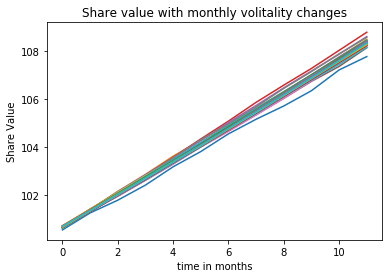

In [4]:
#Import necessary libraries
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

s0 = 100
r = 0.08
sigma = 0.3
gamma = 0.75

#Initialize sharepath
sharepath = [None]  * 50
months = 12


#Step function to calculate share price for current time period.

def step_fxn(st, r, t_delta, Z):
    # volatility for the period [𝑡𝑖,𝑡𝑖+1] is function of share price at time t and some constant sigma 
    sigma_t = st ** (gamma -1) * sigma
    return st * np.exp((r - (sigma_t)**2/2) * t_delta + sigma_t * np.sqrt(t_delta) * Z)


np.random.seed(0)

#iterate through sample ranges
for i in range(1,51):
    sharepath[i-1] = [None] * months
    for j in range(months):
        normarray = norm.rvs(size = i * 1000)
        if j==0:
            sharepath[i-1][j] = np.mean(step_fxn(s0, r, 1/12, normarray))
        else:
            sharepath[i-1][j] = np.mean(step_fxn(sharepath[i-1][j-1], r, 1/12, normarray))

plt.title("Share value with monthly volitality changes")
index = range(1,13)

#plt.plot(sharepath[0])
for i in range(1,51):
    plt.plot(sharepath[i-1], label=str(i)+"000 samples")

plt.xlabel("time in months")
plt.ylabel("Share Value")
#plt.legend()
plt.show()

#3 Augmented code with Monte Carlo Estimate and Standard Deviation

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import math

S_0 = 100
r = 0.08
sigma = 0.3

K = 100
T = 1
t=0

def terminal_shareprice(S_0, risk_free_rate, sigma, Z, T):
    """Generates the terminal share price, given some randon normal values, Z """
    return S_0 * np.exp((risk_free_rate - sigma**2/2) * T + sigma * np.sqrt(T) * Z)

def discounted_call_payoff(S_T, K, risk_free_rate, T):
    """Function to evaluating the discounted payoff of put in Monto Carlo Estimation"""
    return np.exp(-risk_free_rate * T) * np.maximum(S_T - K, 0)

#Code for generating Monte Carlo Estimates of vanilla European Call Options
np.random.seed(0)

#Empty arrays which can be used to store estimate vaues of different sample sizes.
mcall_estimates = [None]*50
mcall_std = [None]*50

#Generating Monte Carlo estimates as a function of sample size.  
for i in range(1, 51):
    norm_array = norm.rvs(size = i * 1000)
    term_val = terminal_shareprice(S_0, r, sigma, norm_array, T)
    mcall_val = discounted_call_payoff(term_val, K, r, T)
    mcall_estimates[i-1] = np.mean(mcall_val)
    mcall_std[i-1] = np.std(mcall_val)/np.sqrt(i*1000)


In [2]:
#Plot the Monte Carlo estimates generated above with respect to sample size, as well
#as three standard deviation error bounds around these estimates

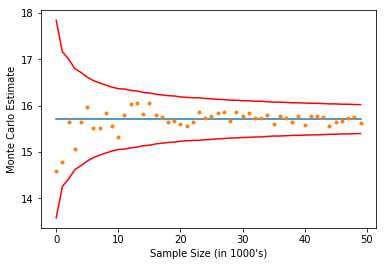

In [3]:
d_1 = (math.log(S_0/K) + (r + sigma**2/2) * (T-t)) / (sigma * math.sqrt(T-t))
d_2 = d_1 - sigma * math.sqrt(T-t)
analytical_call_val = S_0 * norm.cdf(d_1) - K * math.exp(-r * (T - t)) * norm.cdf(d_2)

#Plot the Monte Carlo estimates, the analytical European put option value, and three standard deviation error bounds.
import matplotlib.pyplot as plt

plt.plot([analytical_call_val] * 50)
plt.plot(mcall_estimates, '.')
plt.plot(analytical_call_val + np.array(mcall_std)*3, 'r')
plt.plot(analytical_call_val - np.array(mcall_std)*3, 'r')
plt.xlabel("Sample Size (in 1000's)")
plt.ylabel("Monte Carlo Estimate")
plt.show()